In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("END-TO-END FOOTBALL PLAYER ROLE CLASSIFICATION PIPELINE")
print("="*70)



END-TO-END FOOTBALL PLAYER ROLE CLASSIFICATION PIPELINE


In [ ]:
# STEP 1: DATA LOADING & EXPLORATION
print("\n[STEP 1] LOADING & EXPLORING DATA")
print("-"*70)

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cleaned_data.csv')

# Drop unwanted columns
data = data.drop(columns=['Unnamed: 0','attacking_work_rate_encoded','defensive_work_rate_encoded'])
print(f"✓ Dropped: Unnamed: 0, attacking_work_rate_encoded, defensive_work_rate_encoded")

# Create target and features
y = data['player_role']
X = data.drop(columns=['player_role'])

print(f"✓ Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
print(f"✓ Target classes: {len(y.unique())}")
print(f"\n✓ Original class distribution:")
print(y.value_counts())



[STEP 1] LOADING & EXPLORING DATA
----------------------------------------------------------------------
✓ Dropped: Unnamed: 0, attacking_work_rate_encoded, defensive_work_rate_encoded
✓ Dataset loaded: 11060 samples, 34 features
✓ Target classes: 8

✓ Original class distribution:
player_role
4    5336
1    2099
0     955
3     795
2     755
7     447
5     370
6     303
Name: count, dtype: int64


In [ ]:
# STEP 2: DATA CLEANING
print("\n[STEP 2] DATA CLEANING")
print("-"*70)

# Check NaN
nan_count = X.isnull().sum().sum() + y.isnull().sum()
print(f"✓ NaN values found: {nan_count}")

# Drop if any NaN exists
X_clean = X.dropna()
y_clean = y[X_clean.index]
print(f"✓ Dataset after cleaning: {X_clean.shape[0]} samples")

# Check duplicates
dup_count = X_clean.duplicated().sum()
print(f"✓ Duplicate rows: {dup_count}")



[STEP 2] DATA CLEANING
----------------------------------------------------------------------
✓ NaN values found: 0
✓ Dataset after cleaning: 11060 samples
✓ Duplicate rows: 7



[STEP 3] CUSTOM CLASS BALANCING (Moderate, Varied Sizes)
----------------------------------------------------------------------
Original class distribution:
  Class 0: 955 players
  Class 1: 2099 players
  Class 2: 755 players
  Class 3: 795 players
  Class 4: 5336 players
  Class 5: 370 players
  Class 6: 303 players
  Class 7: 447 players

Target distribution (custom balanced):
  Class 0: 700 players
  Class 1: 1000 players
  Class 2: 750 players
  Class 3: 700 players
  Class 4: 1200 players
  Class 5: 650 players
  Class 6: 600 players
  Class 7: 700 players
Total: 6300 samples

[Step 1] Oversampling small classes with SMOTE...
✓ After SMOTE: 11890 samples
Distribution after SMOTE:
  Class 0: 955
  Class 1: 2099
  Class 2: 755
  Class 3: 795
  Class 4: 5336
  Class 5: 650
  Class 6: 600
  Class 7: 700

[Step 2] Undersampling large classes...
✓ After undersampling: 6300 samples

FINAL BALANCED DISTRIBUTION

Role Distribution:
--------------------------------------------------------

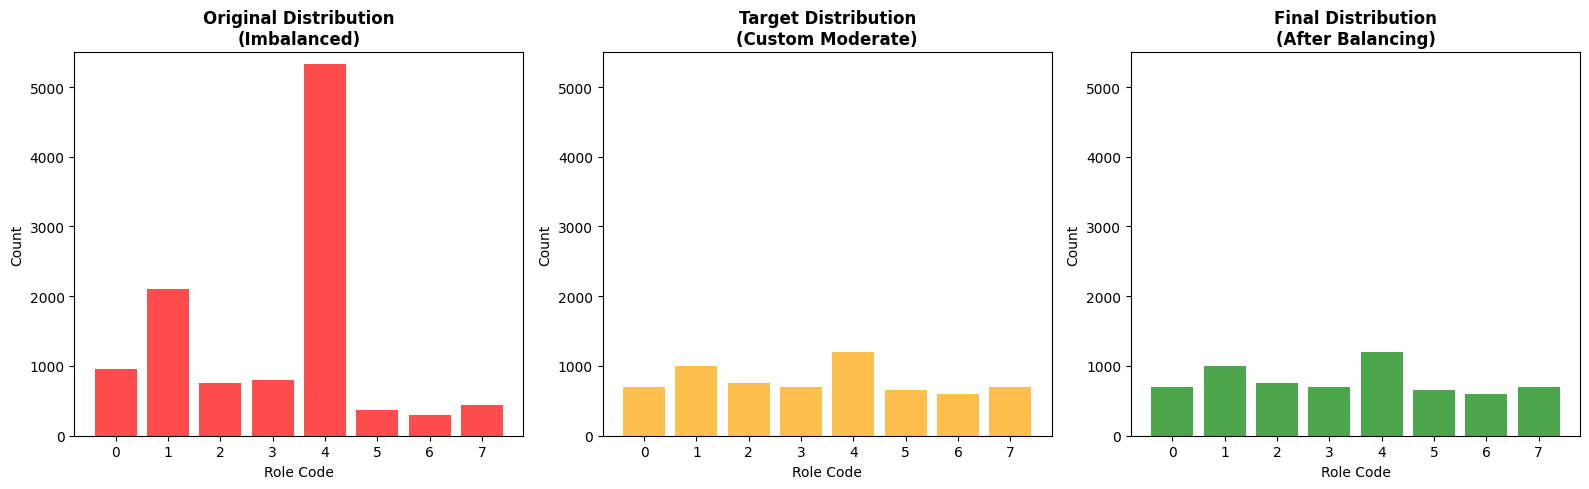


✓ Custom balancing complete!


In [ ]:
# STEP 3: CLASS BALANCING WITH CUSTOM DICTIONARY (Moderate, Not Equal)
print("\n[STEP 3] CUSTOM CLASS BALANCING (Moderate, Varied Sizes)")
print("-"*70)

print("Original class distribution:")
orig_dist = y_clean.value_counts().sort_index()
for idx, count in orig_dist.items():
    print(f"  Class {idx}: {count} players")

# ============================================================
# CUSTOM BALANCING STRATEGY
# ============================================================
# CM (4) has 5336 → reduce to 1200 (keep ~23%)
# CB (1) has 2099 → reduce to 1000 (keep ~48%)
# Others → keep at 600-800 range (moderate reduction)
# Smallest (W:303, AM:370, ST:447) → increase to 600-700 (light oversample)

sampling_strategy_dict = {
    0: 700,    # GK: 955 → 700 (reduce 27%)
    1: 1000,   # CB: 2099 → 1000 (reduce 52%) - high but needed
    2: 750,    # FB: 755 → 750 (reduce 1%) - keep most
    3: 700,    # DM: 795 → 700 (reduce 12%)
    4: 1200,   # CM: 5336 → 1200 (reduce 78%) - MAJOR reduction
    5: 650,    # AM: 370 → 650 (increase 76%)
    6: 600,    # W: 303 → 600 (increase 98%)
    7: 700     # ST: 447 → 700 (increase 57%)
}

print("\nTarget distribution (custom balanced):")
total_custom = sum(sampling_strategy_dict.values())
for role_idx, target_count in sampling_strategy_dict.items():
    print(f"  Class {role_idx}: {target_count} players")
print(f"Total: {total_custom} samples")

# ============================================================
# Step 1: OVERSAMPLE (create synthetic for small classes)
# ============================================================
print("\n[Step 1] Oversampling small classes with SMOTE...")

# Only oversample classes that need it (AM, W, ST)
oversample_dict = {
    5: 650,   # AM: 370 → 650
    6: 600,   # W: 303 → 600
    7: 700    # ST: 447 → 700
}

smote = SMOTE(random_state=42, k_neighbors=3, sampling_strategy=oversample_dict)
X_after_smote, y_after_smote = smote.fit_resample(X_clean, y_clean)
print(f"\u2713 After SMOTE: {len(X_after_smote)} samples")
print("Distribution after SMOTE:")
smote_dist = pd.Series(y_after_smote).value_counts().sort_index()
for idx, count in smote_dist.items():
    print(f"  Class {idx}: {count}")

# ============================================================
# Step 2: UNDERSAMPLE (reduce majority classes)
# ============================================================
print("\n[Step 2] Undersampling large classes...")

# Undersample the larger classes (classes already at target or less will not be included)
undersample_dict = {
    0: 700,    # GK
    1: 1000,   # CB
    2: 750,    # FB
    3: 700,    # DM
    4: 1200    # CM (MAJOR reduction)
}

undersampler = RandomUnderSampler(random_state=42, sampling_strategy=undersample_dict)
X_balanced, y_balanced = undersampler.fit_resample(X_after_smote, y_after_smote)
print(f"\u2713 After undersampling: {len(X_balanced)} samples")

# ============================================================
# Final Distribution Summary
# ============================================================
print("\n" + "="*70)
print("FINAL BALANCED DISTRIBUTION")
print("="*70)

final_dist = pd.Series(y_balanced).value_counts().sort_index()
role_names = {0: 'GK', 1: 'CB', 2: 'FB', 3: 'DM', 4: 'CM', 5: 'AM', 6: 'W', 7: 'ST'}

print("\nRole Distribution:")
print("-"*70)
for role_idx in range(8):
    count = final_dist[role_idx]
    orig_count = orig_dist[role_idx]
    change_pct = ((count - orig_count) / orig_count) * 100
    role_name = role_names[role_idx]

    symbol = "↓" if change_pct < 0 else "↑"
    print(f"{role_name:3} (Class {role_idx}): {count:5} | Original: {orig_count:5} | {symbol} {change_pct:+.1f}%")

print("-"*70)
print(f"Total samples: {len(X_balanced)}")
print(f"Average per role: {len(X_balanced) / 8:.0f}")
print(f"Min: {final_dist.min()}, Max: {final_dist.max()}")
print(f"Imbalance ratio (max/min): {final_dist.max() / final_dist.min():.2f}x")
print("="*70)

# ============================================================
# Comparison Visualization
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Original
axes[0].bar(orig_dist.index, orig_dist.values, color='red', alpha=0.7)
axes[0].set_title('Original Distribution\n(Imbalanced)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Role Code')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, 5500)

# Target
target_vals = [sampling_strategy_dict[i] for i in range(8)]
axes[1].bar(range(8), target_vals, color='orange', alpha=0.7)
axes[1].set_title('Target Distribution\n(Custom Moderate)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Role Code')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, 5500)

# Final
axes[2].bar(final_dist.index, final_dist.values, color='green', alpha=0.7)
axes[2].set_title('Final Distribution\n(After Balancing)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Role Code')
axes[2].set_ylabel('Count')
axes[2].set_ylim(0, 5500)

plt.tight_layout()
plt.show()

print("\n\u2713 Custom balancing complete!")

In [ ]:
# STEP 4: FEATURE SCALING
print("\n[STEP 4] SCALING FEATURES")
print("-"*70)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)
print(f"✓ Features scaled using StandardScaler")
print(f"✓ Number of features: {X_scaled.shape[1]}")



[STEP 4] SCALING FEATURES
----------------------------------------------------------------------
✓ Features scaled using StandardScaler
✓ Number of features: 34


In [ ]:
# STEP 5: TRAIN-TEST SPLIT
print("\n[STEP 5] TRAIN-TEST SPLIT")
print("-"*70)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

print(f"✓ Training set: {len(X_train)} samples")
print(f"✓ Test set: {len(X_test)} samples")
print(f"✓ Train/Test ratio: {len(X_train)/len(X_test):.2f}:1")



[STEP 5] TRAIN-TEST SPLIT
----------------------------------------------------------------------
✓ Training set: 5040 samples
✓ Test set: 1260 samples
✓ Train/Test ratio: 4.00:1


In [ ]:
# STEP 6: MODEL TRAINING (Stacking Ensemble)
print("\n[STEP 6] TRAINING STACKING ENSEMBLE")
print("-"*70)

# Base models
base_models = [
    ('dt', DecisionTreeClassifier(max_depth=8, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ('ada', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=100, learning_rate=0.5, random_state=42))
]

# Meta-learner
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

# Stacking
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5
)

stacking.fit(X_train, y_train)
print(f"✓ Stacking model trained successfully!")



[STEP 6] TRAINING STACKING ENSEMBLE
----------------------------------------------------------------------
✓ Stacking model trained successfully!


In [ ]:
# STEP 7: MODEL EVALUATION
print("\n[STEP 7] EVALUATING MODEL")
print("-"*70)

# Predictions
y_pred = stacking.predict(X_test)
y_pred_proba = stacking.predict_proba(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"✓ Overall Accuracy: {accuracy * 100:.2f}%\n")

# Classification Report
print("✓ Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"✓ Confusion Matrix shape: {cm.shape}")



[STEP 7] EVALUATING MODEL
----------------------------------------------------------------------
✓ Overall Accuracy: 99.37%

✓ Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       140
           1       1.00      1.00      1.00       200
           2       1.00      0.99      1.00       150
           3       1.00      1.00      1.00       140
           4       0.99      0.99      0.99       240
           5       0.98      0.98      0.98       130
           6       0.99      0.98      0.99       120
           7       0.99      0.99      0.99       140

    accuracy                           0.99      1260
   macro avg       0.99      0.99      0.99      1260
weighted avg       0.99      0.99      0.99      1260

✓ Confusion Matrix shape: (8, 8)



[STEP 8] SAVING MODEL & RESULTS
----------------------------------------------------------------------
✓ Model saved: pipeline_stacking_model.pkl
✓ Scaler saved: pipeline_scaler.pkl
✓ Predictions saved: pipeline_predictions.csv


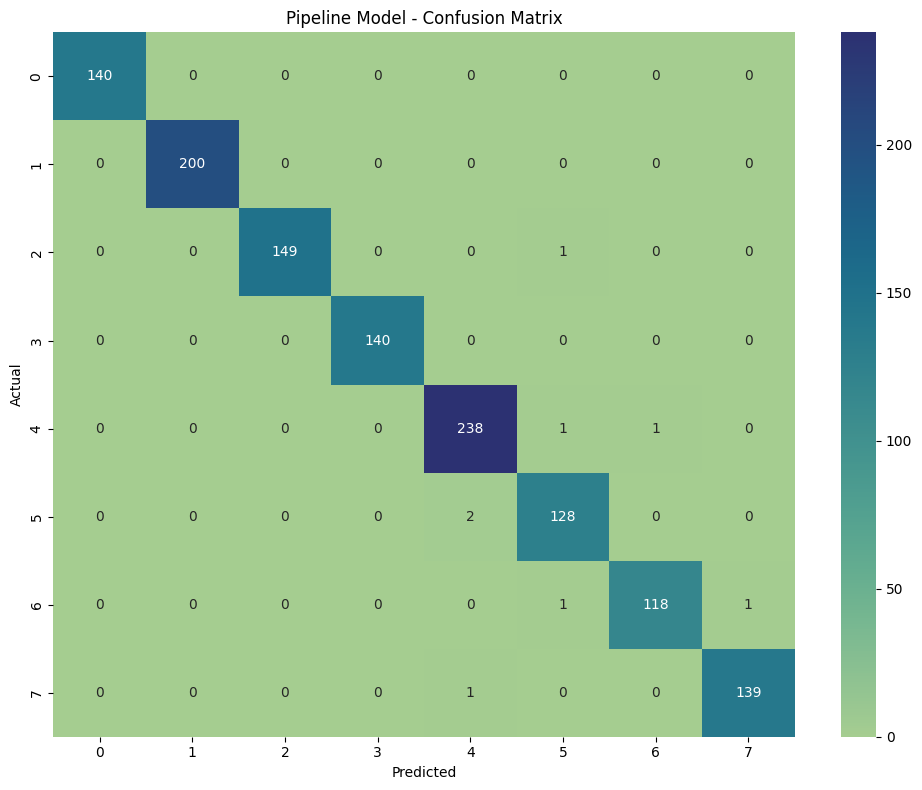

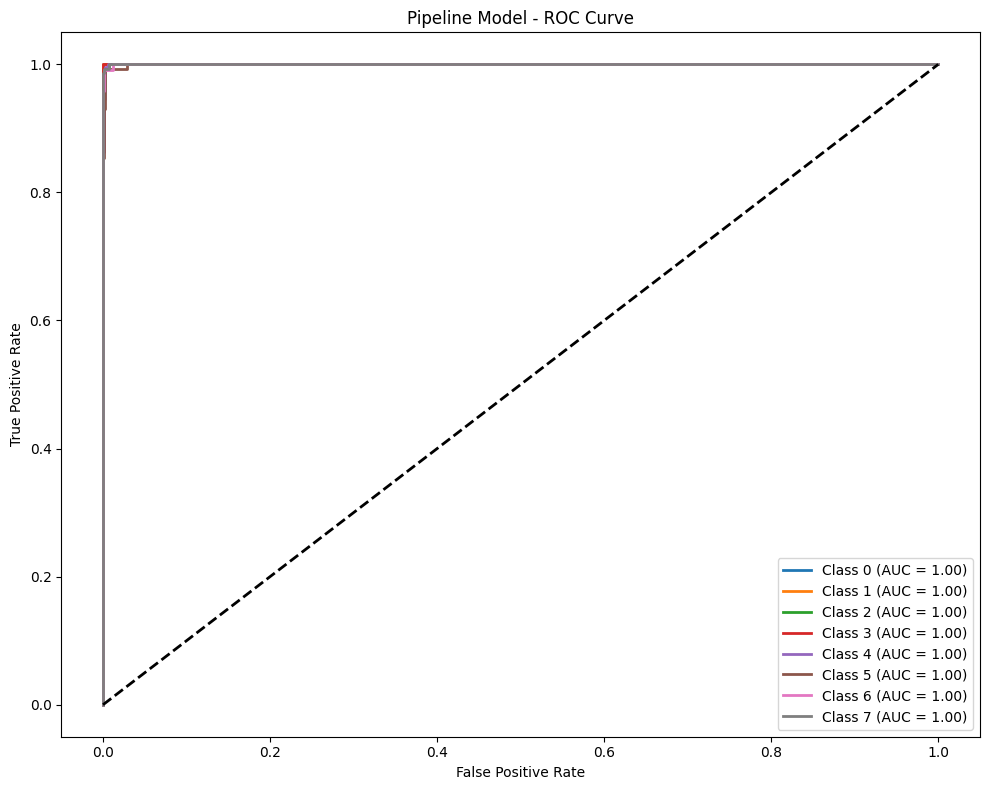


PIPELINE COMPLETED SUCCESSFULLY!


In [ ]:
# STEP 8: SAVE MODEL & RESULTS
print("\n[STEP 8] SAVING MODEL & RESULTS")
print("-"*70)

# Save model and scaler
joblib.dump(stacking, 'pipeline_stacking_model.pkl')
joblib.dump(scaler, 'pipeline_scaler.pkl')
print(f"✓ Model saved: pipeline_stacking_model.pkl")
print(f"✓ Scaler saved: pipeline_scaler.pkl")

# Save predictions
pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred
}).to_csv('pipeline_predictions.csv', index=False)
print(f"✓ Predictions saved: pipeline_predictions.csv")

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='crest')
plt.title('Pipeline Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
print()
print()
print()
print()


# ROC Curve
y_test_bin = label_binarize(y_test, classes=stacking.classes_)
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {stacking.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pipeline Model - ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*70)


In [ ]:
# INTERACTIVE SLIDER PREDICTOR (FIXED)
print("\n" + "="*70)
print("INTERACTIVE PLAYER ROLE PREDICTOR WITH SLIDERS")
print("="*70)

# Load saved model and scaler
stacking_loaded = joblib.load('pipeline_stacking_model.pkl')
scaler_loaded = joblib.load('pipeline_scaler.pkl')

# Get feature names from ORIGINAL data (before balancing)
feature_names = X.columns.tolist()
print(f"\n\u2713 Number of features: {len(feature_names)}")
print(f"\u2713 Feature names: {feature_names}\n")

# Role mapping
role_mapping = {0: 'GK', 1: 'CB', 2: 'FB', 3: 'DM', 4: 'CM', 5: 'AM', 6: 'W', 7: 'ST'}

# Get min and max values for each feature (from CLEANED data)
feature_min = X_clean.min().values
feature_max = X_clean.max().values

print(f"\u2713 Feature ranges extracted from training data")
print(f"\u2713 Min shape: {feature_min.shape}, Max shape: {feature_max.shape}\n")

# ============================================================
# CREATE SIMPLE PREDICTOR (No widgets - just values)
# ============================================================

# Create default player with middle values
default_player = np.array([
    (feature_min[i] + feature_max[i]) / 2
    for i in range(len(feature_names))
]).reshape(1, -1)

print("="*70)
print("INTERACTIVE PLAYER PREDICTOR")
print("="*70)

def predict_from_values(*slider_values):
    """Predict player role from slider values"""
    try:
        # Convert slider values to array
        player_stats = np.array(slider_values).reshape(1, -1)

        # Check if correct number of features
        if player_stats.shape[1] != len(feature_names):
            print(f"\u274c Error: Expected {len(feature_names)} features, got {player_stats.shape[1]}")
            return

        # Scale the data
        player_stats_scaled = scaler_loaded.transform(player_stats)

        # Predict
        pred_class = stacking_loaded.predict(player_stats_scaled)[0]
        pred_proba = stacking_loaded.predict_proba(player_stats_scaled)[0]

        # Display results
        print("\n" + "="*70)
        print("PREDICTION RESULT")
        print("="*70)
        print(f"\n\u2713 Predicted Role: {role_mapping[pred_class]}")
        print(f"\u2713 Confidence: {pred_proba[pred_class]*100:.2f}%")
        print(f"\nProbability Distribution:")
        for role_code in range(len(role_mapping)):
            prob = pred_proba[role_code] * 100
            bar = "\u2588" * int(prob / 5)
            print(f"  {role_mapping[role_code]:3}: {prob:5.2f}% {bar}")
        print("\n" + "="*70)

    except Exception as e:
        print(f"\u274c Error in prediction: {e}")

# ============================================================
# TEST WITH EXAMPLE VALUES
# ============================================================
print("\n[TEST 1] Predicting with default middle values:")
test_player_1 = default_player[0]
predict_from_values(*test_player_1)

# ============================================================
# CREATE INTERACTIVE SLIDERS
# ============================================================
print("\n" + "="*70)
print("ADJUST SLIDERS TO PREDICT")
print("="*70 + "\n")

from ipywidgets import FloatSlider, interactive, Output
import ipywidgets as widgets

# Create a slider for each feature
sliders = {}
for i, feature in enumerate(feature_names):
    slider = FloatSlider(
        value=(feature_min[i] + feature_max[i]) / 2,  # Middle value
        min=feature_min[i],
        max=feature_max[i],
        step=(feature_max[i] - feature_min[i]) / 100,
        description=f"{feature[:12]}",  # Truncate long names
        continuous_update=True,
        layout=widgets.Layout(width='400px')
    )
    sliders[feature] = slider

# Create interactive interface
output = Output()

def on_slider_change(change): # Modified to accept the 'change' argument
    """Called when any slider changes"""
    with output:
        output.clear_output(wait=True)
        # Get all slider values in correct order
        slider_values = [sliders[feat].value for feat in feature_names]
        predict_from_values(*slider_values)

# Attach handlers to all sliders
for feature in feature_names:
    sliders[feature].observe(on_slider_change, names='value')

# Display sliders
print("Features:")
slider_display = widgets.VBox([sliders[feat] for feat in feature_names])
display(slider_display)
display(output)

# Initial prediction
print("\n[Initial] Making prediction with default values...")
with output:
    slider_values = [sliders[feat].value for feat in feature_names]
    predict_from_values(*slider_values)


INTERACTIVE PLAYER ROLE PREDICTOR WITH SLIDERS

✓ Number of features: 34
✓ Feature names: ['crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'positioning', 'vision', 'penalties', 'aggression', 'interceptions', 'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes', 'preferred_foot_encoded']

✓ Feature ranges extracted from training data
✓ Min shape: (34,), Max shape: (34,)

INTERACTIVE PLAYER PREDICTOR

[TEST 1] Predicting with default middle values:

PREDICTION RESULT

✓ Predicted Role: CM
✓ Confidence: 98.85%

Probability Distribution:
  GK :  0.31% 
  CB :  0.06% 
  FB :  0.23% 
  DM :  0.17% 
  CM : 98.85% ███████████████████
  AM :  0.15% 
  W  :  0.09% 
  ST :  0.14% 


ADJUST SLIDERS TO P

Output()


[Initial] Making prediction with default values...
